In [1]:
import numpy as np
np.random.seed(42)
import sys
import cProfile
import h5py
sys.path.insert(0, '../..')
%reload_ext memory_profiler
%reload_ext autoreload
%autoreload 1
import allel; print(allel.__version__)
%aimport allel.stats.selection

0.21.0.dev0


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
callset = h5py.File('/data/coluzzi/ag1000g/data/phase1/release/AR3/haplotypes/main/hdf5/ag1000g.phase1.ar3.haplotypes.3R.h5',
                    mode='r')
callset

<HDF5 file "ag1000g.phase1.ar3.haplotypes.3R.h5" (mode r)>

In [4]:
n_variants = 200000
n_samples = 50

In [5]:
h = allel.GenotypeArray(callset['3R']['calldata/genotype'][:n_variants, :n_samples]).to_haplotypes()
h

,0,1,2,3,4,...,95,96,97,98,99
0,0,0,0,0,0,...,0,0,0,0,0
1,0,0,0,0,0,...,0,0,0,0,0
2,0,0,0,0,0,...,0,0,0,0,0
3,0,0,0,0,0,...,0,0,0,0,0
4,0,0,0,0,0,...,0,0,0,0,0


In [6]:
pos = callset['3R']['variants/POS'][:n_variants]
pos

array([  1252,   1262,   1271, ..., 884821, 884824, 884827], dtype=int32)

In [7]:
ac = h.count_alleles(max_allele=1)
is_seg = ac.is_segregating() & (ac.min(axis=1) > 1)
h_seg = h.compress(is_seg, axis=0)
pos_seg = pos.compress(is_seg)
ac_seg = ac.compress(is_seg, axis=0)
np.count_nonzero(is_seg)

29163

In [8]:
%%time
nsl = allel.stats.nsl(h_seg)

CPU times: user 1.87 s, sys: 0 ns, total: 1.87 s
Wall time: 1.86 s


In [9]:
nsl

array([ 1.81802864,  3.47513775,  4.67942404, ..., -0.91332681,
       -0.0641944 , -0.08138509])

In [10]:
np.count_nonzero(np.isnan(nsl)), np.count_nonzero(~np.isnan(nsl))

(0, 29163)

In [11]:
np.count_nonzero(np.isinf(nsl)), np.count_nonzero(~np.isinf(nsl))

(0, 29163)

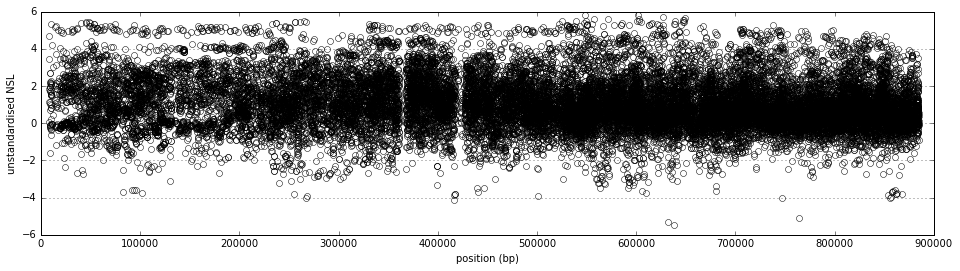

In [12]:
plt.figure(figsize=(16, 4))
plt.plot(pos_seg, nsl, linestyle=' ', marker='o', mfc='none')
plt.grid(axis='y')
plt.xlabel('position (bp)')
plt.ylabel('unstandardised NSL');

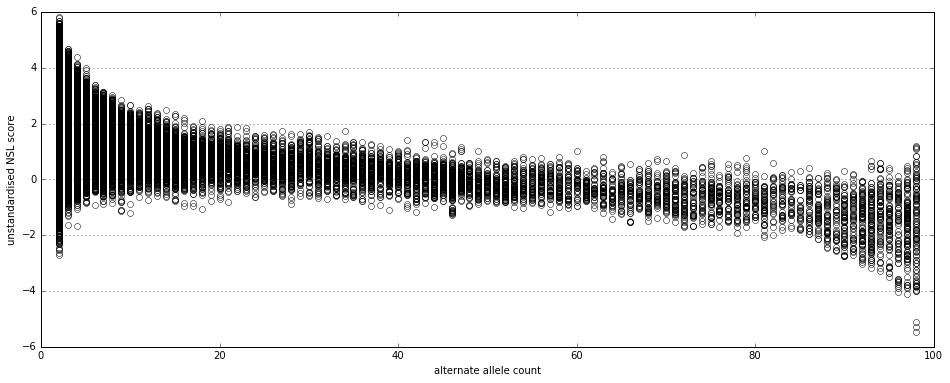

In [13]:
plt.figure(figsize=(16, 6))
plt.plot(ac_seg[:, 1], nsl, linestyle=' ', marker='o', mfc='none')
plt.xlabel('alternate allele count')
plt.ylabel('unstandardised NSL score')
plt.grid(axis='y');

In [14]:
import scipy as sp
import scipy.stats

In [17]:
bins = np.arange(h.n_haplotypes+2)
mean_nsl_by_aac, _, _ = sp.stats.binned_statistic(ac_seg[:, 1], nsl, statistic='mean', bins=bins)
std_nsl_by_aac, _, _ = sp.stats.binned_statistic(ac_seg[:, 1], nsl, statistic='std', bins=bins)

In [18]:
bins.shape

(102,)

In [19]:
mean_nsl_by_aac.shape, std_nsl_by_aac.shape

((101,), (101,))

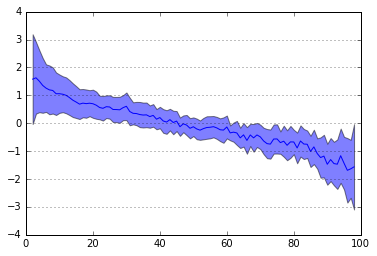

In [20]:
plt.fill_between(bins[:-1], 
                 mean_nsl_by_aac - std_nsl_by_aac, 
                 mean_nsl_by_aac + std_nsl_by_aac,
                 alpha=.5)
plt.plot(bins[:-1], mean_nsl_by_aac)
plt.grid(axis='y');

In [21]:
nsl_centred = np.empty_like(nsl)
nsl_normed = np.empty_like(nsl)

In [22]:
for aac in bins[:-1]:
    loc = ac_seg[:, 1] == aac
    nsl_centred[loc] = (nsl[loc] - mean_nsl_by_aac[aac]) 
    nsl_normed[loc] =  nsl_centred[loc] / std_nsl_by_aac[aac]

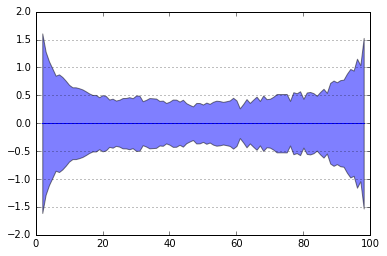

In [24]:
mean_nsl_by_aac_centred, _, _ = sp.stats.binned_statistic(ac_seg[:, 1], nsl_centred, statistic='mean', bins=bins)
std_nsl_by_aac_centred, _, _ = sp.stats.binned_statistic(ac_seg[:, 1], nsl_centred, statistic='std', bins=bins)
plt.fill_between(bins[:-1], 
                 mean_nsl_by_aac_centred - std_nsl_by_aac_centred, 
                 mean_nsl_by_aac_centred + std_nsl_by_aac_centred,
                 alpha=.5)
plt.plot(bins[:-1], mean_nsl_by_aac_centred)
plt.grid(axis='y');

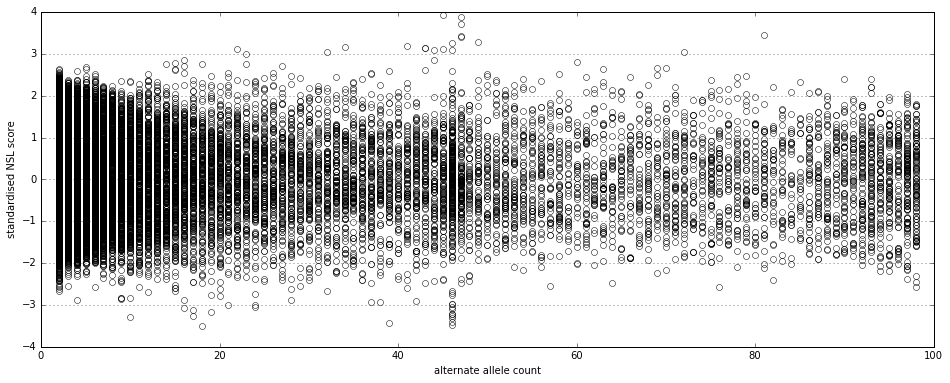

In [25]:
plt.figure(figsize=(16, 6))
plt.plot(ac_seg[:, 1], nsl_normed, linestyle=' ', marker='o', mfc='none')
plt.xlabel('alternate allele count')
plt.ylabel('standardised NSL score')
plt.grid(axis='y');

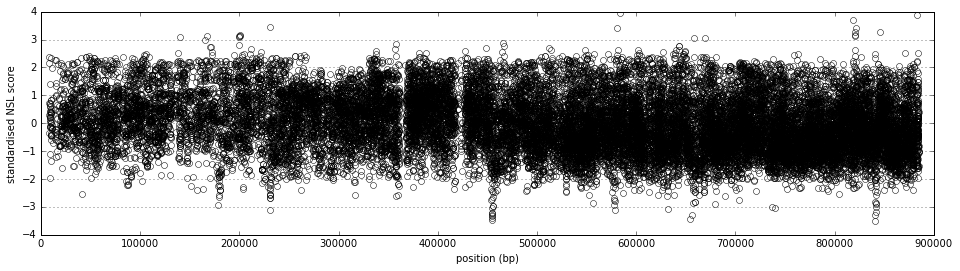

In [26]:
plt.figure(figsize=(16, 4))
plt.plot(pos_seg, nsl_normed, linestyle=' ', marker='o', mfc='none')
plt.grid(axis='y')
plt.xlabel('position (bp)')
plt.ylabel('standardised NSL score');

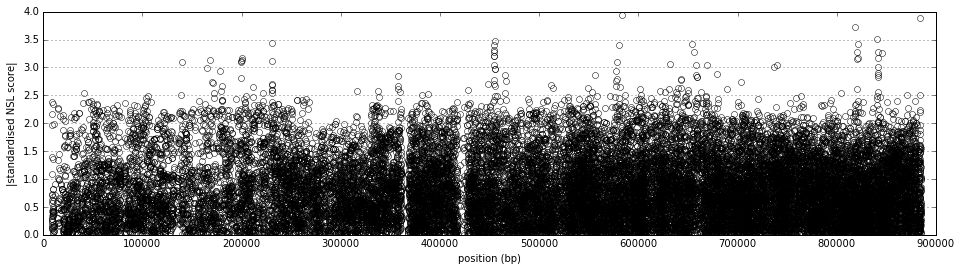

In [27]:
plt.figure(figsize=(16, 4))
plt.plot(pos_seg, np.abs(nsl_normed), linestyle=' ', marker='o', mfc='none')
plt.grid(axis='y')
plt.xlabel('position (bp)')
plt.ylabel('|standardised NSL score|');

In [28]:
cProfile.run('allel.stats.nsl(h_seg)', sort='time')

         2216546 function calls in 2.431 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.809    0.404    2.421    1.211 stats.pyx:554(ssl01_scan_int8)
   116655    0.481    0.000    0.481    0.000 {method 'reduce' of 'numpy.ufunc' objects}
   116652    0.340    0.000    1.099    0.000 _methods.py:53(_mean)
   233315    0.180    0.000    0.188    0.000 {built-in method numpy.core.multiarray.array}
   116652    0.153    0.000    0.165    0.000 _methods.py:43(_count_reduce_items)
   116658    0.089    0.000    0.108    0.000 stringsource:985(memoryview_fromslice)
   116652    0.083    0.000    1.182    0.000 fromnumeric.py:2796(mean)
   116652    0.070    0.000    1.252    0.000 stats.pyx:630(ssl2nsl)
   116660    0.056    0.000    0.232    0.000 numeric.py:414(asarray)
   116653    0.045    0.000    0.057    0.000 numeric.py:484(asanyarray)
   233309    0.034    0.000    0.034    0.000 {built-in method builtins

In [29]:
ihs = allel.stats.ihs(h_seg, pos_seg, min_ehh=0.05, include_edges=True)

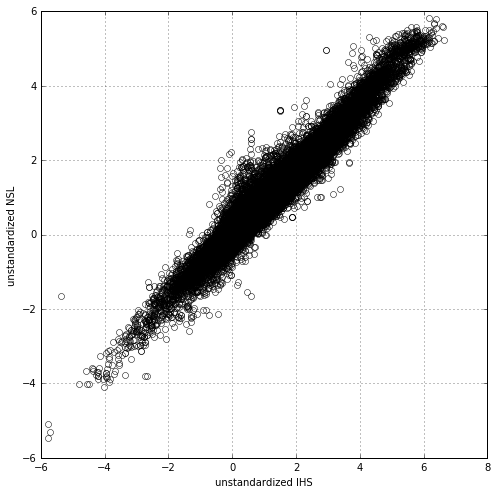

In [34]:
plt.figure(figsize=(8, 8))
plt.plot(ihs, nsl, marker='o', linestyle=' ', mfc='none')
plt.xlabel('unstandardized IHS')
plt.ylabel('unstandardized NSL')
plt.grid(axis='both');

In [35]:
bins = np.arange(h.n_haplotypes+2)
mean_ihs_by_aac, _, _ = sp.stats.binned_statistic(ac_seg[:, 1], ihs, statistic='mean', bins=bins)
std_ihs_by_aac, _, _ = sp.stats.binned_statistic(ac_seg[:, 1], ihs, statistic='std', bins=bins)

In [36]:
ihs_centred = np.empty_like(ihs)
ihs_normed = np.empty_like(ihs)

for aac in bins[:-1]:
    loc = ac_seg[:, 1] == aac
    ihs_centred[loc] = (ihs[loc] - mean_ihs_by_aac[aac]) 
    ihs_normed[loc] =  ihs_centred[loc] / std_ihs_by_aac[aac]

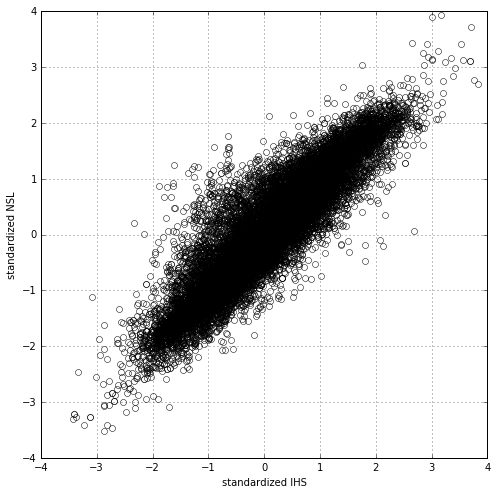

In [37]:
plt.figure(figsize=(8, 8))
plt.plot(ihs_normed, nsl_normed, marker='o', linestyle=' ', mfc='none')
plt.xlabel('standardized IHS')
plt.ylabel('standardized NSL')
plt.grid(axis='both');